In [37]:
!pip install statsmodels prophet

In [38]:
# check torch gpu
import torch

device = None

print("<!> Selecting GPU as main device <!>")
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    device = torch.device("cuda")
    print("<!> Using: " + torch.cuda.get_device_name(0) + "<!>")
else:
    print("<!> No GPU available <!>")
    exit(0)

<!> Selecting GPU as main device <!>
<!> Using: NVIDIA GeForce GTX 1050<!>


In [39]:
import pandas as pd

print("<!> Loading test dataframe <!>")
df = pd.read_csv('/root/test/train_transactions.csv')

<!> Loading test dataframe <!>


<!> Loading train dataframe <!>
<!> Training LSTM <!>
Epoch 1, Train Loss: 0.3601, Val Loss: 0.5976
Epoch 2, Train Loss: 0.1338, Val Loss: 0.0705
Epoch 3, Train Loss: 0.0398, Val Loss: 0.0907
Epoch 4, Train Loss: 0.0294, Val Loss: 0.1431
Epoch 5, Train Loss: 0.0341, Val Loss: 0.0542
Epoch 6, Train Loss: 0.0241, Val Loss: 0.1074
Epoch 7, Train Loss: 0.0252, Val Loss: 0.0741
Epoch 8, Train Loss: 0.0224, Val Loss: 0.0649
Epoch 9, Train Loss: 0.0231, Val Loss: 0.0836
Epoch 10, Train Loss: 0.0204, Val Loss: 0.0663
Epoch 11, Train Loss: 0.0190, Val Loss: 0.0713
Epoch 12, Train Loss: 0.0212, Val Loss: 0.0620
Epoch 13, Train Loss: 0.0216, Val Loss: 0.0530
Epoch 14, Train Loss: 0.0187, Val Loss: 0.0537
Epoch 15, Train Loss: 0.0159, Val Loss: 0.0426
Epoch 16, Train Loss: 0.0160, Val Loss: 0.0523
Epoch 17, Train Loss: 0.0154, Val Loss: 0.0484
Epoch 18, Train Loss: 0.0161, Val Loss: 0.0270
Epoch 19, Train Loss: 0.0115, Val Loss: 0.0395
Epoch 20, Train Loss: 0.0113, Val Loss: 0.0229
Epoch 21, Train

19:31:30 - cmdstanpy - INFO - Chain [1] start processing


Epoch 36, Train Loss: 0.0061, Val Loss: 0.0188
Epoch 37, Train Loss: 0.0058, Val Loss: 0.0084
Epoch 38, Train Loss: 0.0056, Val Loss: 0.0117
Early stopping triggered
<!> Done <!>


19:31:30 - cmdstanpy - INFO - Chain [1] done processing
/root/miniconda3/envs/ai/lib/python3.10/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(



=== Evaluation for Hybrid LSTM-ES + Prophet Model ===
  - MAPE: 0.26
  - SMAPE: 26.90
  - MSE: 41502470.31
  - RMSE: 6442.24
  - R² Score: -3.16


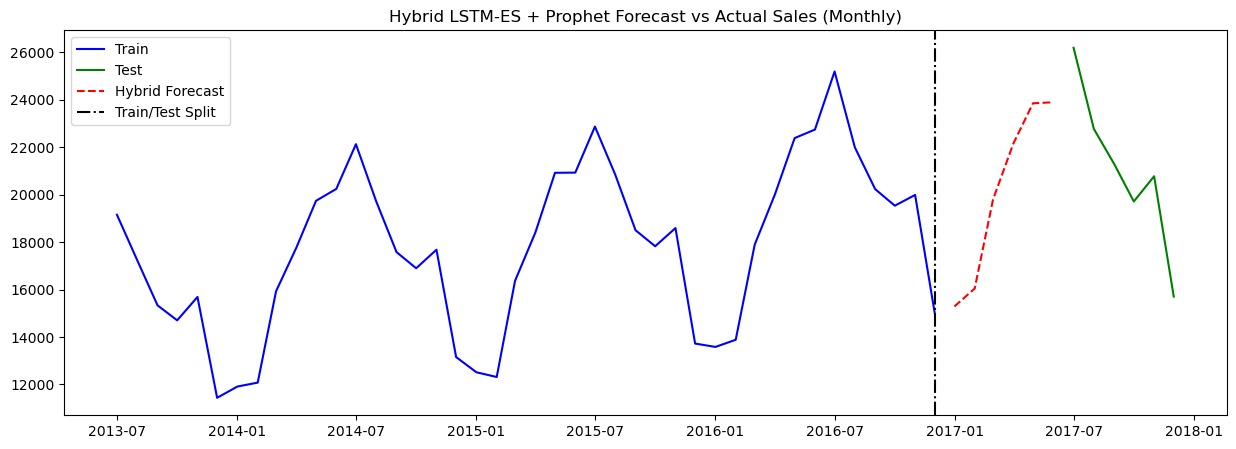


Monthly Sales Comparison:
         ds  yhat_forecast  y_actual       error  error_percentage
0   2013-07   19427.983655   19153.0 -274.983655         -1.435721
1   2013-08   16950.063690   17234.0  283.936310          1.647536
2   2013-09   15364.701877   15333.0  -31.701877         -0.206756
3   2013-10   14704.417261   14701.0   -3.417261         -0.023245
4   2013-11   15831.027121   15687.0 -144.027121         -0.918130
5   2013-12   11360.077373   11436.0   75.922627          0.663891
6   2014-01   11916.810703   11910.0   -6.810703         -0.057185
7   2014-02   11886.517277   12075.0  188.482723          1.560934
8   2014-03   15983.823051   15927.0  -56.823051         -0.356772
9   2014-04   17697.286824   17765.0   67.713176          0.381161
10  2014-05   19867.267322   19740.0 -127.267322         -0.644718
11  2014-06   20235.975154   20242.0    6.024846          0.029764
12  2014-07   22083.650325   22128.0   44.349675          0.200423
13  2014-08   19805.751331   19714.

In [40]:

import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from math import sqrt
from prophet import Prophet
import matplotlib.pyplot as plt

# Function to create sequences
def create_sequences(data, seq_length):
    if len(data) <= seq_length:
        print(f"Warning: Data length ({len(data)}) <= SEQ_LENGTH ({seq_length}). No sequences created.")
        return np.array([]), np.array([])
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length, 0]  # Predict main series
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Exponential Smoothing
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return np.array(result)

# Load and preprocess data
print("<!> Loading train dataframe <!>")
df = pd.read_csv('/root/test/train_transactions.csv')
df.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])

# Add features
item_id = '2'
df['lag1'] = df[item_id].shift(1).bfill()
df['rolling_mean_7'] = df[item_id].rolling(window=7, min_periods=1).mean()

# Aggregate to monthly
df['month'] = df['date'].dt.to_period('M')
monthly_df = df.groupby('month').agg({item_id: 'sum', 'lag1': 'sum', 'rolling_mean_7': 'mean'}).reset_index()
monthly_df['date'] = monthly_df['month'].dt.to_timestamp()

# Split data
train_df = monthly_df[monthly_df['date'] < '2017-01-01']
test_df = monthly_df[monthly_df['date'] >= '2017-01-01']

# Prepare feature arrays
train_series = train_df[[item_id, 'lag1', 'rolling_mean_7']].values
test_series = test_df[[item_id, 'lag1', 'rolling_mean_7']].values

# Smooth main series
alpha = 0.3
smoothed_train_series = exponential_smoothing(train_series[:, 0], alpha).reshape(-1, 1)
smoothed_test_series = exponential_smoothing(test_series[:, 0], alpha).reshape(-1, 1)
train_series[:, 0] = smoothed_train_series.flatten()
test_series[:, 0] = smoothed_test_series.flatten()

# Normalize
scaler = MinMaxScaler()
train_series = scaler.fit_transform(train_series)
test_series = scaler.transform(test_series)

# Sequences
SEQ_LENGTH = 6  # Reduced to 6 months to fit 12-month test set
X_train_full, y_train_full = create_sequences(train_series, SEQ_LENGTH)
X_test, y_test = create_sequences(test_series, SEQ_LENGTH)

# Check if sequences are valid
if X_train_full.size == 0 or X_test.size == 0:
    print(f"Error: Train ({len(train_series)}) or Test ({len(test_series)}) set too small for SEQ_LENGTH={SEQ_LENGTH}.")
    exit(1)

# Convert to tensors
X_train_full = torch.tensor(X_train_full, dtype=torch.float32).to(device)
y_train_full = torch.tensor(y_train_full, dtype=torch.float32).to(device).unsqueeze(1)  # Fix shape
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device).unsqueeze(1)  # Fix shape

# Validation split
val_size = max(1, int(0.2 * len(X_train_full)))  # Ensure at least 1 sample
X_val, y_val = X_train_full[-val_size:], y_train_full[-val_size:]
X_train, y_train = X_train_full[:-val_size], y_train_full[:-val_size]

# Dataset
class DemandDataset(Dataset):
    def __init__(self, X, y):
        self.X, self.y = X, y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = DemandDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)  # Smaller batch size

# LSTM Model
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, output_size)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_step_output = lstm_out[:, -1, :]
        x = self.fc1(last_step_output)
        x = self.relu(x)
        return self.fc2(x)

# Model setup
INPUT_SIZE = 3  # item_id, lag1, rolling_mean_7
HIDDEN_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 1
DROPOUT_RATE = 0.2

model = LSTMPredictor(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT_RATE).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 50

# Training with early stopping
def train_model_with_early_stopping():
    best_loss = float('inf')
    patience, max_patience = 0, 10
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = criterion(val_pred, y_val).item()
        print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
        if val_loss < best_loss:
            best_loss = val_loss
            patience = 0
            torch.save(model.state_dict(), "/root/test/best_lstm_model.pth")
        else:
            patience += 1
        if patience > max_patience:
            print("Early stopping triggered")
            break

print("<!> Training LSTM <!>")
train_model_with_early_stopping()
print("<!> Done <!>")

# Load best model
model.load_state_dict(torch.load("/root/test/best_lstm_model.pth", weights_only=True))

# Predictions
model.eval()
with torch.no_grad():
    lstm_train_pred = model(X_train_full).cpu().numpy()
    lstm_test_pred = model(X_test).cpu().numpy()

# Inverse transform
lstm_train_pred = scaler.inverse_transform(
    np.concatenate([lstm_train_pred, np.zeros((lstm_train_pred.shape[0], 2))], axis=1))[:, 0]
lstm_test_pred = scaler.inverse_transform(
    np.concatenate([lstm_test_pred, np.zeros((lstm_test_pred.shape[0], 2))], axis=1))[:, 0]

# Prophet data
train_prophet_df = train_df[['date', item_id]].rename(columns={'date': 'ds', item_id: 'y'})
test_prophet_df = test_df[['date', item_id]].rename(columns={'date': 'ds', item_id: 'y'})
train_prophet_df = train_prophet_df.iloc[SEQ_LENGTH:].copy()
test_prophet_df = test_prophet_df.iloc[SEQ_LENGTH:].copy()

assert len(train_prophet_df) == len(lstm_train_pred), f"Train mismatch: {len(train_prophet_df)} vs {len(lstm_train_pred)}"
assert len(test_prophet_df) == len(lstm_test_pred), f"Test mismatch: {len(test_prophet_df)} vs {len(lstm_test_pred)}"

train_prophet_df['lstm_pred'] = lstm_train_pred
test_prophet_df['lstm_pred'] = lstm_test_pred

# Normalize LSTM predictions
lstm_scaler = MinMaxScaler()
train_prophet_df['lstm_pred'] = lstm_scaler.fit_transform(train_prophet_df['lstm_pred'].values.reshape(-1, 1)).flatten()
test_prophet_df['lstm_pred'] = lstm_scaler.transform(test_prophet_df['lstm_pred'].values.reshape(-1, 1)).flatten()

# Prophet model
prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=True)
prophet_model.add_regressor('lstm_pred')
prophet_model.fit(train_prophet_df)

# Future dataframe
future_dates = prophet_model.make_future_dataframe(periods=len(test_prophet_df), freq='M')
future_df = pd.concat([train_prophet_df[['ds', 'lstm_pred']], test_prophet_df[['ds', 'lstm_pred']]], axis=0)
future = future_dates.merge(future_df, on='ds', how='left')
future['lstm_pred'] = future['lstm_pred'].ffill()

# Predictions
forecast = prophet_model.predict(future)
test_forecast = forecast.tail(len(test_prophet_df))

# Evaluation
def evaluate_forecast(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    smape = 100 * np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
    r2 = r2_score(y_true, y_pred)
    print("\n=== Evaluation for Hybrid LSTM-ES + Prophet Model ===")
    print(f"  - MAPE: {mape:.2f}")
    print(f"  - SMAPE: {smape:.2f}")
    print(f"  - MSE: {mse:.2f}")
    print(f"  - RMSE: {rmse:.2f}")
    print(f"  - R² Score: {r2:.2f}")

y_true = test_prophet_df['y'].values
y_pred = test_forecast['yhat'].values
evaluate_forecast(y_true, y_pred)

# Plot
plt.figure(figsize=(15, 5))
plt.plot(train_prophet_df['ds'], train_prophet_df['y'], label="Train", color="blue")
plt.plot(test_prophet_df['ds'], test_prophet_df['y'], label="Test", color="green")
plt.plot(test_forecast['ds'], test_forecast['yhat'], label="Hybrid Forecast", color="red", linestyle="dashed")
plt.axvline(train_prophet_df['ds'].iloc[-1], color="black", linestyle="-.", label="Train/Test Split")
plt.legend()
plt.title("Hybrid LSTM-ES + Prophet Forecast vs Actual Sales (Monthly)")
plt.show()

# Monthly comparison
forecasted_sales = forecast.groupby(forecast['ds'].dt.to_period('M'))['yhat'].mean().reset_index()
actual_sales = pd.concat([train_prophet_df, test_prophet_df]).groupby('ds')['y'].mean().reset_index()
actual_sales['ds'] = actual_sales['ds'].dt.to_period('M')

forecasted_sales.rename(columns={'yhat': 'yhat_forecast'}, inplace=True)
actual_sales.rename(columns={'y': 'y_actual'}, inplace=True)

comparison = pd.merge(forecasted_sales, actual_sales, on='ds', how='inner')
comparison['error'] = comparison['y_actual'] - comparison['yhat_forecast']
comparison['error_percentage'] = (comparison['error'] / comparison['y_actual']) * 100
print("\nMonthly Sales Comparison:")
print(comparison)
mean_error_percentage = comparison['error_percentage'].mean()
print(f"Mean Error Percentage: {mean_error_percentage:.2f}%")